## Plot mutation prediction results

In this notebook, we'll compare the results of our mutation prediction experiments for expression and methylation data only, predicting a binary mutated/not mutated label for each gene (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
# this is a mess, TODO move results into same location
results_dir1 = Path(cfg.results_dirs['mutation'], 'bmiq_results', 'gene').resolve()
results_dir2 = Path(cfg.results_dirs['mutation'], 'bmiq_results_2', 'gene').resolve()
results_dir3 = Path(cfg.results_dirs['mutation'], 'bmiq_results_me_control', 'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df1 = au.load_stratified_prediction_results(results_dir1, 'gene')
results_df1.loc[results_df1.training_data == 'me_27k', 'training_data'] = 'me_27k_corrected'
results_df2 = au.load_stratified_prediction_results(results_dir2, 'gene')
results_df2.loc[results_df2.training_data == 'me_27k', 'training_data'] = 'me_27k_corrected'
results_df3 = au.load_stratified_prediction_results(results_dir3, 'gene')

results_df = pd.concat((results_df1, results_df2, results_df3))

print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(13848, 9)
[ 1 42]
['me_27k_corrected' 'expression' 'me_27k']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.50000,0.073465,MAP3K1,me_27k_corrected,shuffled,1,train,0,gene
1,0.50000,0.081967,MAP3K1,me_27k_corrected,shuffled,1,test,0,gene
2,0.51566,0.085234,MAP3K1,me_27k_corrected,shuffled,1,cv,0,gene
3,0.50000,0.077766,MAP3K1,me_27k_corrected,shuffled,1,train,1,gene
4,0.50000,0.069079,MAP3K1,me_27k_corrected,shuffled,1,test,1,gene


In [4]:
all_results_df = pd.DataFrame()
for training_data in results_df.training_data.unique():
    data_results_df = au.compare_results(results_df[results_df.training_data == training_data],
                                         identifier='identifier',
                                         metric='aupr',
                                         correction=True,
                                         correction_method='fdr_bh',
                                         correction_alpha=SIG_ALPHA,
                                         verbose=True)
    data_results_df['training_data'] = training_data
    data_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    all_results_df = pd.concat((all_results_df, data_results_df))
    
# now filter out genes that don't have comparisons for all data types
data_type_counts = all_results_df.groupby('gene').count().training_data
valid_genes = data_type_counts[data_type_counts == len(results_df.training_data.unique())].index
all_results_df = all_results_df[
    all_results_df.gene.isin(valid_genes)
]
all_results_df.sort_values(by='p_value').head(10)

shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for CYLD, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for MSH6, skipping
shapes unequal for PAX5, skipping
shapes unequal for SMO, skipping
shapes unequal for TSHR, skipping
shapes unequal for ABL1, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH6, skipping
shapes unequal for PAX5, skipping
shapes unequal for SMO, skipping
shapes unequal for TSHR, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for CYLD, skipping
shapes unequal for HIST1H3B, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH6, skipping
shapes unequal for PTPN11, skipping


,gene,delta_mean,p_value,corr_pval,reject_null,training_data
89,TP53,0.412102,3.276535e-20,3.014412e-18,True,expression
74,PTEN,0.561969,1.731779e-19,7.966184e-18,True,expression
2,APC,0.508811,1.767503e-17,1.626103e-15,True,me_27k
2,APC,0.524759,2.850148e-17,2.593635e-15,True,me_27k_corrected
44,IDH1,0.429478,5.022225e-17,2.310223e-15,True,me_27k
1,APC,0.548485,2.865031e-16,8.786096e-15,True,expression
14,BRAF,0.511599,1.081554e-15,4.921072e-14,True,me_27k_corrected
28,EGFR,0.546531,2.233725e-15,4.238102e-14,True,expression
82,SMAD4,0.353328,2.303316e-15,4.238102e-14,True,expression
14,BRAF,0.516559,2.308155e-15,7.078341e-14,True,me_27k


expression: 50/88
me_27k: 36/88
me_27k_corrected: 40/88


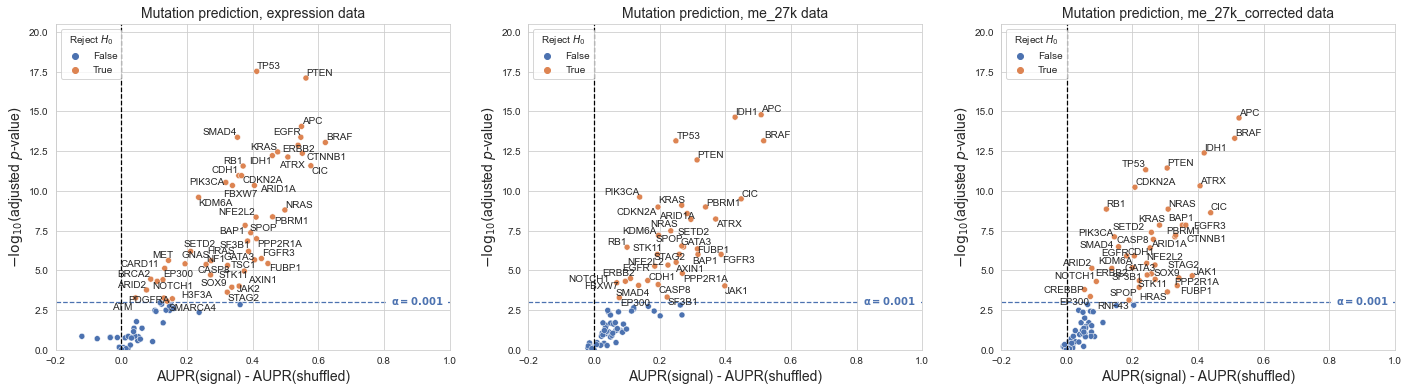

In [5]:
all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)

sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

# all plots should have the same axes for a fair comparison
xlim = (-0.2, 1.0)
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot mutation prediction from expression, in a volcano-like plot
for ix, training_data in enumerate(sorted(all_results_df.training_data.unique())):
    ax = axarr[ix]
    data_results_df = all_results_df[all_results_df.training_data == training_data]
    sns.scatterplot(data=data_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)
    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25, zorder=-1)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.9, -np.log10(SIG_ALPHA)+0.1,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor(),
            zorder=0)
    ax.set_xlabel('AUPR(signal) - AUPR(shuffled)', size=14)
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$', size=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, {} data'.format(training_data), size=14)

    # label genes and adjust text to not overlap
    # automatic alignment isn't perfect, can align by hand in inkscape if necessary
    text_labels = label_points(data_results_df['delta_mean'],
                               data_results_df['nlog10_p'],
                               data_results_df.gene,
                               ax)
    
    adjust_text(text_labels,
                ax=ax, 
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{}'.format(
        training_data,
        np.count_nonzero(data_results_df.reject_null),
        data_results_df.shape[0]
    ))

shapes unequal for TSHR, skipping
shapes unequal for MSH6, skipping
shapes unequal for HNF1A, skipping
shapes unequal for MLH1, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for ABL1, skipping
shapes unequal for PAX5, skipping


me_27k: 19/92


shapes unequal for ACVR1B, skipping
shapes unequal for ABL1, skipping
size 0 results array for PAX5, skipping


me_27k_corrected: 21/97


shapes unequal for TSHR, skipping
shapes unequal for MSH6, skipping
shapes unequal for HNF1A, skipping
shapes unequal for CYLD, skipping
shapes unequal for MLH1, skipping
shapes unequal for ACVR1B, skipping
shapes unequal for CBL, skipping
shapes unequal for PAX5, skipping


me_27k_corrected: 0/93


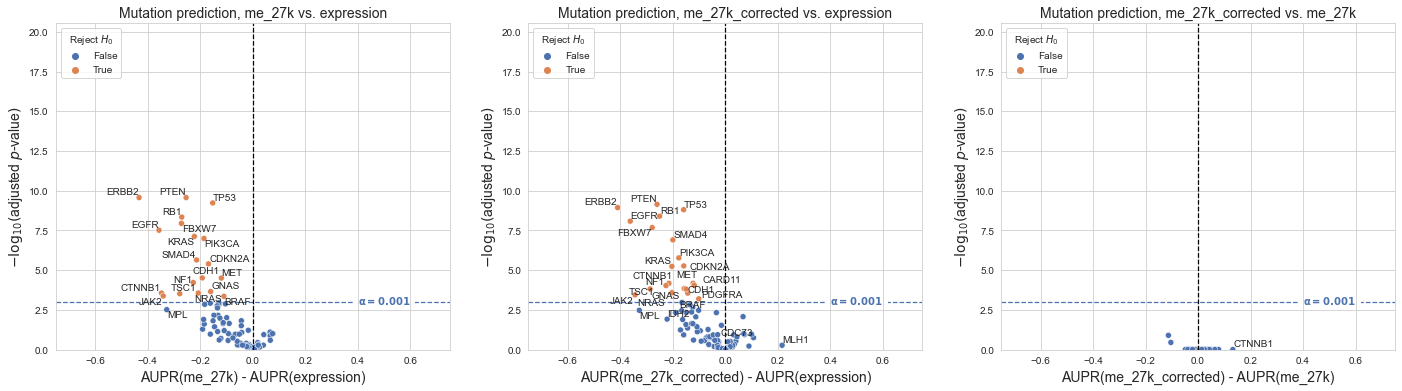

In [6]:
# compare all data modalities against each other
import itertools as it

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if (point['y'] > -np.log10(0.001)) or (point['x'] > 0.1) or (abs(point['x']) > 0.2):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

# all plots should have the same axes for a fair comparison
xlim = (-0.75, 0.75)
# TODO: maybe adjust these afterward?
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

for ix, (train_1, train_2) in enumerate(it.combinations(
            sorted(all_results_df.training_data.unique()), 2)):
    ax = axarr[ix]
    data_results_1_df = results_df[results_df.training_data == train_1]
    data_results_2_df = results_df[results_df.training_data == train_2]
    compare_results_df = au.compare_results(data_results_1_df,
                                            pancancer_df=data_results_2_df,
                                            identifier='identifier',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=SIG_ALPHA,
                                            verbose=True)
    compare_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)
    sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)

    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25, zorder=-1)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.5, -np.log10(SIG_ALPHA)+0.1,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor(),
            zorder=0)
    ax.set_xlabel('AUPR({}) - AUPR({})'.format(train_2, train_1), size=14)
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$', size=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, {} vs. {}'.format(train_2, train_1), size=14)

    text_labels = label_points(compare_results_df['delta_mean'],
                               compare_results_df['nlog10_p'],
                               compare_results_df.gene,
                               ax)
    adjust_text(text_labels,
                ax=ax,
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{}'.format(train_2,
                             np.count_nonzero(compare_results_df.reject_null),
                             compare_results_df.shape[0]))

Looking at the far right plot, we can see that most points are clustered near the origin (small difference in means, very small p-values). This suggests that the predictive performance is essentially the same before and after correction, for all of the genes in our gene set.

(53,)
['IDH1' 'CTNNB1' 'EGFR' 'EP300' 'ERBB2' 'FBXW7' 'FGFR3' 'FUBP1' 'GATA3'
 'CIC' 'CDKN2A' 'APC' 'ARID1A' 'ARID2' 'ATM' 'ATRX' 'GNAS' 'AXIN1' 'BAP1'
 'BRAF' 'BRCA2' 'CARD11' 'CASP8' 'CDH1' 'H3F3A' 'HRAS' 'TSC1' 'PPP2R1A'
 'PTEN' 'RB1' 'PIK3CA' 'SF3B1' 'SMAD4' 'SMARCA4' 'SOX9' 'SPOP' 'STAG2'
 'STK11' 'SETD2' 'PDGFRA' 'NRAS' 'JAK2' 'KDM6A' 'KRAS' 'PBRM1' 'MET' 'NF1'
 'NFE2L2' 'NOTCH1' 'TP53' 'JAK1' 'CREBBP' 'RNF43']


(-0.2, 0.671125)

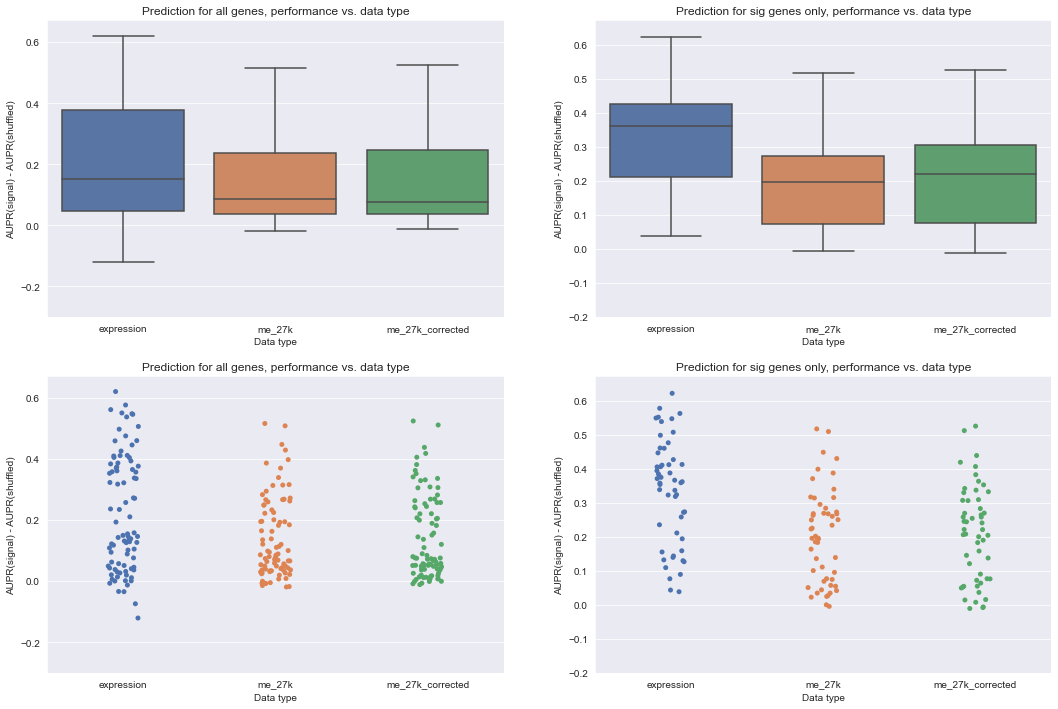

In [7]:
sns.set({'figure.figsize': (18, 12)})
fig, axarr = plt.subplots(2, 2)
all_results_df.sort_values(by='training_data', inplace=True)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0, 0]
sns.boxplot(data=all_results_df, x='training_data', y='delta_mean', ax=ax)
ax.set_title('Prediction for all genes, performance vs. data type')
ax.set_xlabel('Data type')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.3, max(all_results_df.delta_mean + 0.05))


# plot mean performance for genes that are significant for at least one data type
ax = axarr[0, 1]
gene_list = all_results_df[all_results_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.boxplot(data=all_results_df[all_results_df.gene.isin(gene_list)], x='training_data', y='delta_mean', ax=ax)
ax.set_title('Prediction for sig genes only, performance vs. data type')
ax.set_xlabel('Data type')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

ax = axarr[1, 0]
sns.stripplot(data=all_results_df, x='training_data', y='delta_mean', dodge=True, ax=ax)
ax.set_title('Prediction for all genes, performance vs. data type')
ax.set_xlabel('Data type')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.3, max(all_results_df.delta_mean + 0.05))

ax = axarr[1, 1]
sns.stripplot(data=all_results_df[all_results_df.gene.isin(gene_list)], x='training_data', y='delta_mean',
              dodge=True, ax=ax)
ax.set_title('Prediction for sig genes only, performance vs. data type')
ax.set_xlabel('Data type')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

Looking at the aggregate results across all genes, we come to a similar conclusion as for the volcano plots: results distributions are essentially the same with or without correction.